<a href="https://colab.research.google.com/github/benigmatic/Quantum-circuits/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from qiskit import *

In [ ]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector


In [ ]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

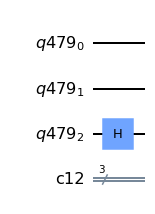

In [ ]:

qc.h(2)
qc.draw(output="mpl")


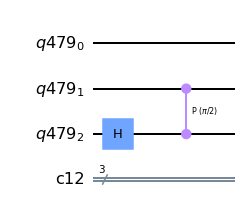

In [ ]:
qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.draw(output="mpl")


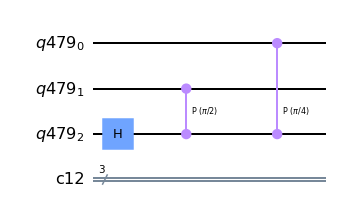

In [ ]:
qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.draw(output="mpl")

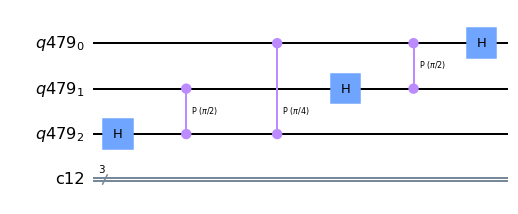

In [ ]:
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw(output="mpl")


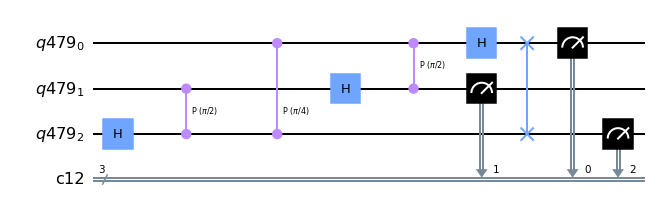

In [ ]:
qc.swap(0,2)
qc.measure(qr,cr)
qc.draw(output="mpl")

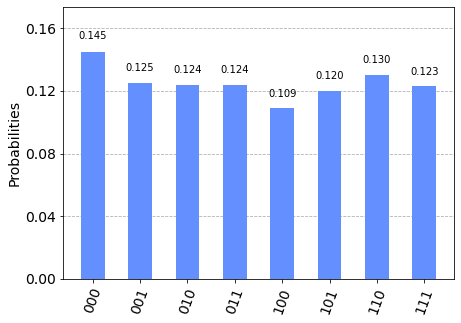

In [ ]:
#Test on clasical simulation (Version 1)
simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.visualization import plot_histogram
 #Execute the circuit (simulation)
result = execute(qc, backend=simulator).result()
plot_histogram(result.get_counts(qc))

C:\Users\krivo\AppData\Local\Temp/ipykernel_9392/462170379.py:6: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  circuit += QFT(num_qubits=3, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='qft')


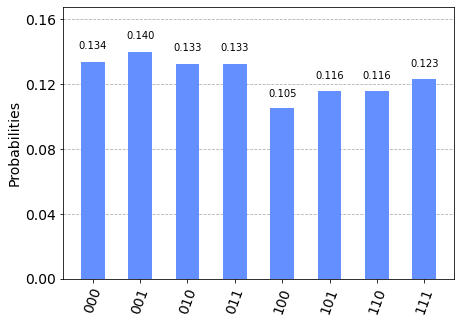

In [ ]:
from qiskit.circuit.library import QFT

q = QuantumRegister(3,'q')
c = ClassicalRegister(3,'c')
circuit = QuantumCircuit(q,c)
circuit += QFT(num_qubits=3, approximation_degree=0, do_swaps=True, inverse=False, insert_barriers=False, name='qft')
circuit.measure(q,c)

simulator = Aer.get_backend('qasm_simulator')
from qiskit.tools.visualization import plot_histogram
 #Execute the circuit (simulation)
result = execute(circuit, backend=simulator).result()
plot_histogram(result.get_counts(circuit))

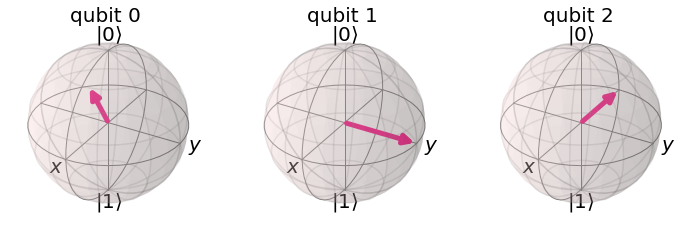

In [ ]:
#Run on real quantum computer (version 2)
"""In order to test it on real device and avoid completely random answers due to superposition
we can proove that QFT is working if we create the state and then run QFT 
in reverse to verify that output would match."""
# reverse QFT 
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)



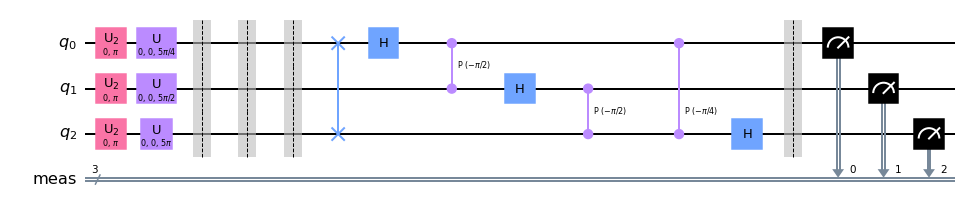

In [ ]:

# Apply the inverse
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw(output ="mpl")

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)


ibmqfactory.load_account:WARNING:2022-03-20 13:05:22,797: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_lima


In [ ]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)


TranspilerError: "Unable to map source basis {('cp', 2), ('barrier', 5), ('h', 1), ('u2', 1), ('measure', 1), ('u', 1), ('swap', 2), ('save_statevector', 3)} to target basis {'id', 'x', 'measure', 'delay', 'cx', 'barrier', 'reset', 'snapshot', 'sx', 'rz'} over library <qiskit.circuit.equivalence.EquivalenceLibrary object at 0x0000015205716730>."

In [ ]:
# If the result is 101 (aka 5) which matches our original output, meaning that the QFT works
counts = job.result().get_counts()
plot_histogram(counts)


In [ ]:
# Version 2 Q-sphere using the plot_bloch_multivector
# 1 basis state |010 >

# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(1)
qc.draw(output="mpl")

sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()

qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
print(statevector)
plot_bloch_multivector(statevector)
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
    qc.save_statevector()


In [ ]:
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)


In [ ]:
"""According to the two testing, the QFT works.
In the first case, I've tested my circuit with the QFT function provided by the qiskit. 
The output were random, I got similar results for my circuit and the qiskit's QFT circuit, 
There was equal random probability distribution.

For second case, I ran the circuit, but in this case I set the basis state to 010 and
ran the circuit, the output was printed out on the shpere and it is visible that a pi/2 happened
for all of the qubits.

For the third case, I tested the circuit on the quantum computer. I created the statevecotrs 
on the simulator. Based on that I then Ran the inverse of te circuit on the quantum computer. 
The result of it above shows that the output produced is predominately 101,
which matched with my original input."""